# Topic Modeling with Latent Dirichlet Allocation
---

Preprocessing and model fitting code made with the help of this article:
>https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

### Importing 
---

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import nltk
import highlighter as hl

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from gensim import corpora, models

np.random.seed(35)

nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

In [33]:
data = pd.read_csv("../data/formatted/admiralbulldog_4_30.csv", 
                   index_col = "time", 
                   parse_dates = True)

data.head(5)

,username,channel,message
time,,,
2019-04-30 08:56:59,collectcalled,admiralbulldog,IF HENRIK WAS AN AniMAL
2019-04-30 08:56:59,laudon,admiralbulldog,gachiHYPER
2019-04-30 08:57:00,hyper_brah,admiralbulldog,WutFace WutFace WutFace WutFace WutFace WutFac...
2019-04-30 08:57:00,felianjo,admiralbulldog,"I LOVE THEM, JUST LET THEM IN CAGES Pepega Clap"
2019-04-30 08:57:00,nevervvinterr,admiralbulldog,gachiHYPER


In [34]:
# Stack all messages for one second onto the same second

documents = pd.DataFrame()

for sec in data.index.unique():
    
    documents = documents.append(
        {"doc": " ".join(data[data.index == sec]["message"].to_list())},
        ignore_index = True
    )
    
documents.index = data.index.unique()

In [35]:
documents.head()

,doc
time,
2019-04-30 08:56:59,IF HENRIK WAS AN AniMAL gachiHYPER
2019-04-30 08:57:00,WutFace WutFace WutFace WutFace WutFace WutFac...
2019-04-30 08:57:01,AYAYA
2019-04-30 08:57:02,gachiBASS gachiBASS
2019-04-30 08:57:03,gachiHYPER Jebaited gachiGASM


In [36]:
# Stack messages by 5 seconds

roll = 5
documents_5 = [" ".join(documents[i:i + roll]["doc"]) for i in range(0, documents.shape[0], roll)]

In [37]:
# Construct a "rolling sum", or rolling 
# concatenation of all the chat messages.

roll = 5
documents_rolling = [" ".join(documents[i:i + roll]["doc"]) for i in range(0, documents.shape[0])]

documents_rolling = pd.Series(documents_rolling, index = documents.index)

documents_rolling.head()

time
2019-04-30 08:56:59    IF HENRIK WAS AN AniMAL gachiHYPER WutFace Wut...
2019-04-30 08:57:00    WutFace WutFace WutFace WutFace WutFace WutFac...
2019-04-30 08:57:01    AYAYA gachiBASS gachiBASS gachiHYPER Jebaited ...
2019-04-30 08:57:02    gachiBASS gachiBASS gachiHYPER Jebaited gachiG...
2019-04-30 08:57:03    gachiHYPER Jebaited gachiGASM CUTE WABBIT AYAY...
dtype: object

In [38]:
WordNetLemmatizer().lemmatize("Pog", pos='v')

'Pog'

In [39]:
SnowballStemmer("english").stem('Pog')

'pog'

In [40]:
def preprocess(text):
    
    result = []
    
    for token in gensim.utils.simple_preprocess(text):
        
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:
            
            token = WordNetLemmatizer().lemmatize(token, pos='v')
            result.append(SnowballStemmer("english").stem(token))
            
    return result

In [41]:
preprocess("Pog PogU OMEGALUL WOW OMEGAWOW Pog D:")

['pog', 'pogu', 'omegalul', 'wow', 'omegawow', 'pog']

In [42]:
doc_sample = documents_5[0]

print('original document: ')

words = [word for word in doc_sample.split(' ')]
    
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['IF', 'HENRIK', 'WAS', 'AN', 'AniMAL', 'gachiHYPER', 'WutFace', 'WutFace', 'WutFace', 'WutFace', 'WutFace', 'WutFace', 'WutFace', 'I', 'LOVE', 'THEM,', 'JUST', 'LET', 'THEM', 'IN', 'CAGES', 'Pepega', 'Clap', 'gachiHYPER', 'AYAYA', 'gachiBASS', 'gachiBASS', 'gachiHYPER', 'Jebaited', 'gachiGASM']


 tokenized and lemmatized document: 
['henrik', 'anim', 'gachihyp', 'wutfac', 'wutfac', 'wutfac', 'wutfac', 'wutfac', 'wutfac', 'wutfac', 'love', 'let', 'cage', 'pepega', 'clap', 'gachihyp', 'ayaya', 'gachibass', 'gachibass', 'gachihyp', 'jebait', 'gachigasm']


In [43]:
processed_docs = pd.Series(documents_5).map(preprocess)
# processed_docs = documents['doc'].map(preprocess)
processed_docs.head()

0    [henrik, anim, gachihyp, wutfac, wutfac, wutfa...
1    [cute, wabbit, ayaya, gachihyp, usagi, ayayaup...
2    [flooooof, head, head, poop, actual, anim, cru...
3    [hotpokket, lay, cirpat, mingle, animal, like,...
4    [cmonbruh, genet, minglul, bruh, isnt, tortur,...
dtype: object

In [44]:
len(processed_docs)

1791

In [45]:
dictionary = gensim.corpora.Dictionary(processed_docs)

dictionary.filter_extremes(no_below = 5, no_above = 0.5, keep_n = 1000)

In [46]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[200]

[(2, 1),
 (19, 2),
 (21, 1),
 (49, 2),
 (59, 3),
 (60, 1),
 (61, 1),
 (81, 3),
 (316, 1),
 (486, 1),
 (518, 1),
 (519, 1),
 (521, 1)]

In [47]:
bow_doc = bow_corpus[200]
for i in range(len(bow_doc)):
    print("Word {} (\"{}\") appears {} time(s).".format(bow_doc[i][0], 
                                                 dictionary[bow_doc[i][0]], 
bow_doc[i][1]))

Word 2 ("clap") appears 1 time(s).
Word 19 ("lulw") appears 2 time(s).
Word 21 ("admiralbulldog") appears 1 time(s).
Word 49 ("pog") appears 2 time(s).
Word 59 ("pogu") appears 3 time(s).
Word 60 ("wtff") appears 1 time(s).
Word 61 ("fathead") appears 1 time(s).
Word 81 ("poggi") appears 3 time(s).
Word 316 ("admiralcpl") appears 1 time(s).
Word 486 ("leav") appears 1 time(s).
Word 518 ("poke") appears 1 time(s).
Word 519 ("pokelawl") appears 1 time(s).
Word 521 ("hunter") appears 1 time(s).


In [48]:
tfidf = models.TfidfModel(bow_corpus)

corpus_tfidf = tfidf[bow_corpus]

In [49]:
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics = 16, 
                                       id2word = dictionary, 
                                       passes = 5, 
                                       workers = 2)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    print()

Topic: 0 
Words: 0.235*"omegalul" + 0.116*"lulw" + 0.090*"lul" + 0.073*"pepelaugh" + 0.033*"trihard" + 0.017*"miss" + 0.016*"morph" + 0.012*"bulldog" + 0.011*"clock" + 0.010*"bruh"

Topic: 1 
Words: 0.163*"gachihyp" + 0.110*"ricardoflick" + 0.089*"hyperclap" + 0.043*"believ" + 0.040*"gachigasm" + 0.035*"clap" + 0.030*"handsup" + 0.018*"lulw" + 0.016*"omegalul" + 0.015*"gachi"

Topic: 2 
Words: 0.147*"pepega" + 0.070*"cycycyweebsout" + 0.069*"lulw" + 0.038*"chikin" + 0.038*"fri" + 0.024*"omegalul" + 0.021*"punoko" + 0.015*"cycycypedo" + 0.014*"save" + 0.014*"star"

Topic: 3 
Words: 0.089*"lul" + 0.071*"pepelaugh" + 0.064*"lulw" + 0.054*"anel" + 0.048*"win" + 0.031*"bettor" + 0.031*"omegalul" + 0.028*"clap" + 0.025*"movi" + 0.023*"sobay"

Topic: 4 
Words: 0.118*"pepegashak" + 0.101*"lulw" + 0.058*"pepehand" + 0.035*"omegalul" + 0.033*"jimmydorri" + 0.027*"pepelaugh" + 0.024*"jimmi" + 0.022*"blessrng" + 0.022*"lul" + 0.020*"monkah"

Topic: 5 
Words: 0.469*"trikool" + 0.464*"claphd" + 0.01

In [50]:
# lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
#                                              num_topics = 5, 
#                                              id2word = dictionary, 
#                                              passes = 5, 
#                                              workers = 2)

# for idx, topic in lda_model_tfidf.print_topics(-1):
#     print('Topic: {} \nWords: {}'.format(idx, topic))
#     print()

In [134]:
unseen_document = "pog pogu"
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):

    print(f"Score: {round(score, 6)} \t Topic {index}: {lda_model.print_topic(index, 5)}")
    print()

Score: 0.6874989867210388 	 Topic 10: 0.130*"pepelaugh" + 0.111*"pog" + 0.081*"wtff" + 0.081*"pepehand" + 0.041*"pogu"

Score: 0.020833000540733337 	 Topic 13: 0.090*"handsup" + 0.068*"pogu" + 0.044*"mnoot" + 0.034*"red" + 0.028*"pepehand"

Score: 0.020833000540733337 	 Topic 14: 0.137*"jebait" + 0.096*"dansgam" + 0.087*"krappa" + 0.055*"ayaya" + 0.043*"wine_glass"

Score: 0.020833000540733337 	 Topic 15: 0.120*"wutfac" + 0.118*"trihard" + 0.076*"clap" + 0.030*"wtff" + 0.028*"gab"

Score: 0.020833000540733337 	 Topic 7: 0.121*"bruh" + 0.053*"pepescoot" + 0.040*"krappa" + 0.035*"wtff" + 0.034*"cmonbruh"

Score: 0.020833000540733337 	 Topic 9: 0.081*"gachipl" + 0.035*"bruh" + 0.029*"permasmug" + 0.027*"lulw" + 0.023*"cmonbruh"

Score: 0.020833000540733337 	 Topic 0: 0.235*"omegalul" + 0.116*"lulw" + 0.090*"lul" + 0.073*"pepelaugh" + 0.033*"trihard"

Score: 0.020833000540733337 	 Topic 1: 0.163*"gachihyp" + 0.110*"ricardoflick" + 0.089*"hyperclap" + 0.043*"believ" + 0.040*"gachigasm"

Sco

In [52]:
unseen_document = documents_rolling[200]
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
print(unseen_document, "\n")
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print(f"Score: {round(score, 6)} \t Topic {index}: {lda_model.print_topic(index, 5)}")
    print()

LUL TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriHard shieeet TreeHard ALL YOU HAD TO DO WAS FOLLOW THE GODAMN TRAIN CJ Pog WTFF Eating meat in 2k19 FeelsWeirdMan Eating meat in 2k19 FeelsWeirdMan CHIKIN TriKool ClapHD TriHard Chicken TriKool Clap TriHard ClapHD BIG 4HEad , MUST BE REALLY SMART Kapp WOOOOO CHIKEN TriKool HELLO GUYS EleGiggle at least he has hair cmonBruh TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool ClapHD TriKool 

In [53]:
df = pd.DataFrame()

for doc in documents_rolling:

    bow_vector = dictionary.doc2bow(preprocess(doc))
    
    scores = pd.DataFrame(lda_model[bow_vector], columns = ["topic", "score"])
    scores = scores.set_index("topic")
    
    df = pd.concat([df, scores.T], axis = 0)
    

In [54]:
df.shape

(8951, 16)

In [55]:
documents.shape

(8951, 1)

In [56]:
df.index = documents.index

docs_with_scores = pd.merge(documents, df, left_index = True, right_index = True)

docs_with_scores = docs_with_scores.fillna(0)

docs_with_scores.head()

,doc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
time,,,,,,,,,,,,,,,,,
2019-04-30 08:56:59,IF HENRIK WAS AN AniMAL gachiHYPER,0.0,0.142835,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.103137,0.715337
2019-04-30 08:57:00,WutFace WutFace WutFace WutFace WutFace WutFac...,0.0,0.208428,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.149137,0.605497
2019-04-30 08:57:01,AYAYA,0.0,0.554672,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.122127,0.0,0.0,0.249330,0.000000
2019-04-30 08:57:02,gachiBASS gachiBASS,0.0,0.619567,0.0,0.0,0.0,0.078144,0.0,0.0,0.0,0.0,0.0,0.096094,0.0,0.0,0.148497,0.000000
2019-04-30 08:57:03,gachiHYPER Jebaited gachiGASM,0.0,0.593171,0.0,0.0,0.0,0.078365,0.0,0.0,0.0,0.0,0.0,0.092748,0.0,0.0,0.178018,0.000000


In [57]:
docs_with_scores.isna().sum().sum()

0

In [58]:
time_series = pd.read_csv("../data/formatted/admiralbulldog_4_30_mps.csv", 
                          index_col = "Unnamed: 0",
                          parse_dates = True).rename(columns = {"0": "mps"})

time_series.head()

,mps
2019-04-30 08:57:00,3
2019-04-30 08:57:01,1
2019-04-30 08:57:02,2
2019-04-30 08:57:03,3
2019-04-30 08:57:04,2


In [59]:
time_series = pd.merge(time_series, docs_with_scores, how = "left", left_index = True, right_index = True)

time_series.head(10)

,mps,doc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2019-04-30 08:57:00,3,WutFace WutFace WutFace WutFace WutFace WutFac...,0.0,0.208428,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.149137,0.605497
2019-04-30 08:57:01,1,AYAYA,0.0,0.554672,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.122127,0.0,0.0,0.249330,0.000000
2019-04-30 08:57:02,2,gachiBASS gachiBASS,0.0,0.619567,0.0,0.0,0.0,0.078144,0.0,0.0,0.0,0.000000,0.0,0.096094,0.0,0.0,0.148497,0.000000
2019-04-30 08:57:03,3,gachiHYPER Jebaited gachiGASM,0.0,0.593171,0.0,0.0,0.0,0.078365,0.0,0.0,0.0,0.000000,0.0,0.092748,0.0,0.0,0.178018,0.000000
2019-04-30 08:57:04,2,CUTE WABBIT AYAYA gachiHYPER,0.0,0.535164,0.0,0.0,0.0,0.093785,0.0,0.0,0.0,0.000000,0.0,0.112274,0.0,0.0,0.190586,0.000000
2019-04-30 08:57:05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30 08:57:06,2,SHOW OFF USAGI AYAYAUP,0.0,0.368995,0.0,0.0,0.0,0.103655,0.0,0.0,0.0,0.346559,0.0,0.105788,0.0,0.0,0.000000,0.000000
2019-04-30 08:57:07,3,looks comfy af gachiHYPER :rabbit_face: ClapHD,0.0,0.414412,0.0,0.0,0.0,0.115315,0.0,0.0,0.0,0.379993,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-04-30 08:57:08,2,4HEad gachiBASS,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.654753,0.0,0.000000,0.0,0.0,0.000000,0.235867
2019-04-30 08:57:09,2,Krappa pepeBASS,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.866063,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [60]:
time_series["doc"].fillna(" ", inplace = True)

time_series.fillna(0, inplace = True)

time_series.head(10)

,mps,doc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2019-04-30 08:57:00,3,WutFace WutFace WutFace WutFace WutFace WutFac...,0.0,0.208428,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.149137,0.605497
2019-04-30 08:57:01,1,AYAYA,0.0,0.554672,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.122127,0.0,0.0,0.249330,0.000000
2019-04-30 08:57:02,2,gachiBASS gachiBASS,0.0,0.619567,0.0,0.0,0.0,0.078144,0.0,0.0,0.0,0.000000,0.0,0.096094,0.0,0.0,0.148497,0.000000
2019-04-30 08:57:03,3,gachiHYPER Jebaited gachiGASM,0.0,0.593171,0.0,0.0,0.0,0.078365,0.0,0.0,0.0,0.000000,0.0,0.092748,0.0,0.0,0.178018,0.000000
2019-04-30 08:57:04,2,CUTE WABBIT AYAYA gachiHYPER,0.0,0.535164,0.0,0.0,0.0,0.093785,0.0,0.0,0.0,0.000000,0.0,0.112274,0.0,0.0,0.190586,0.000000
2019-04-30 08:57:05,0,,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-04-30 08:57:06,2,SHOW OFF USAGI AYAYAUP,0.0,0.368995,0.0,0.0,0.0,0.103655,0.0,0.0,0.0,0.346559,0.0,0.105788,0.0,0.0,0.000000,0.000000
2019-04-30 08:57:07,3,looks comfy af gachiHYPER :rabbit_face: ClapHD,0.0,0.414412,0.0,0.0,0.0,0.115315,0.0,0.0,0.0,0.379993,0.0,0.000000,0.0,0.0,0.000000,0.000000
2019-04-30 08:57:08,2,4HEad gachiBASS,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.654753,0.0,0.000000,0.0,0.0,0.000000,0.235867
2019-04-30 08:57:09,2,Krappa pepeBASS,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.866063,0.0,0.000000,0.0,0.0,0.000000,0.000000


## Plotting
---

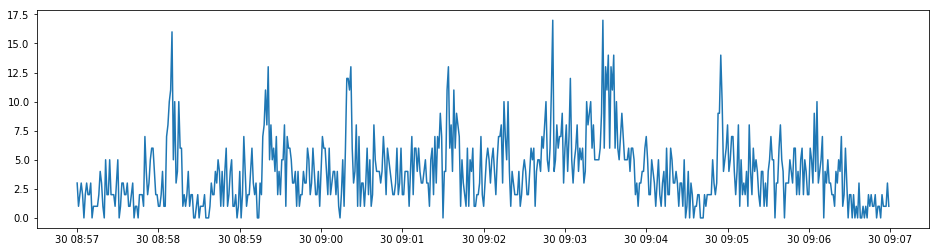

In [61]:
plt.figure(figsize = (16,4))
plt.plot(time_series["mps"][0:600]);

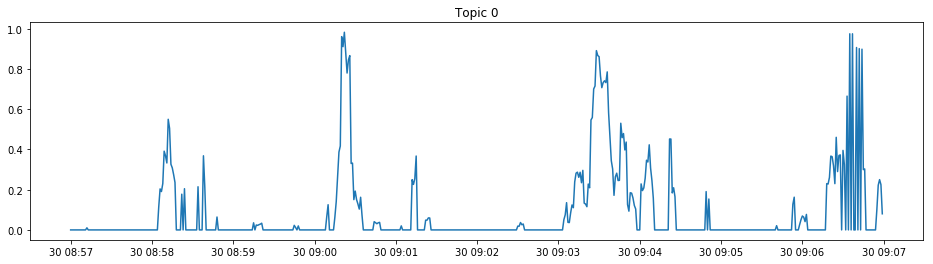

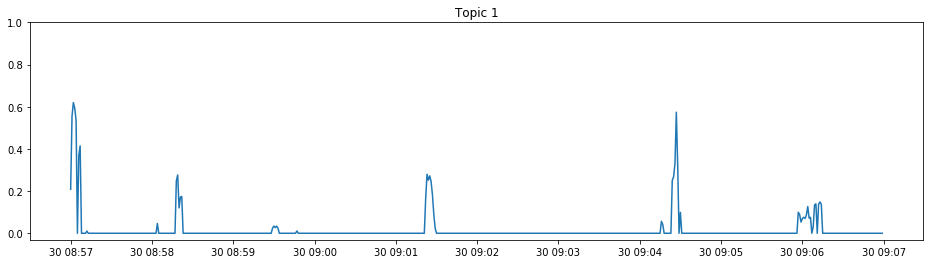

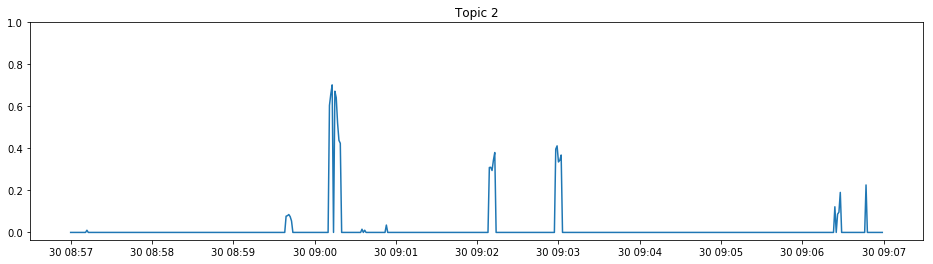

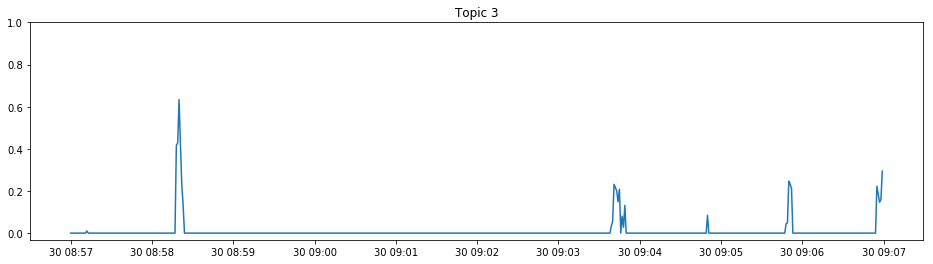

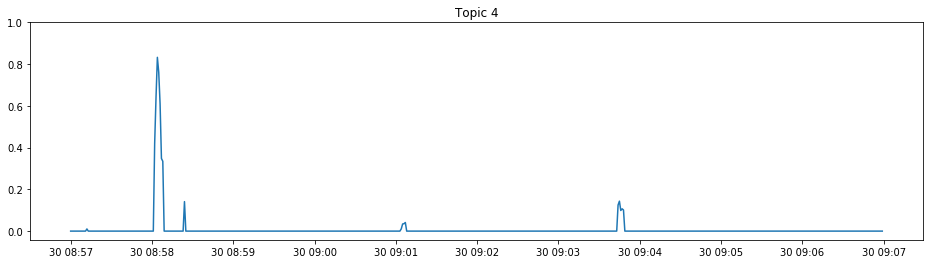

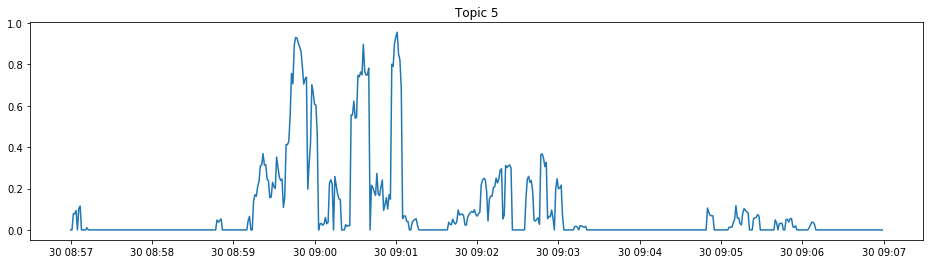

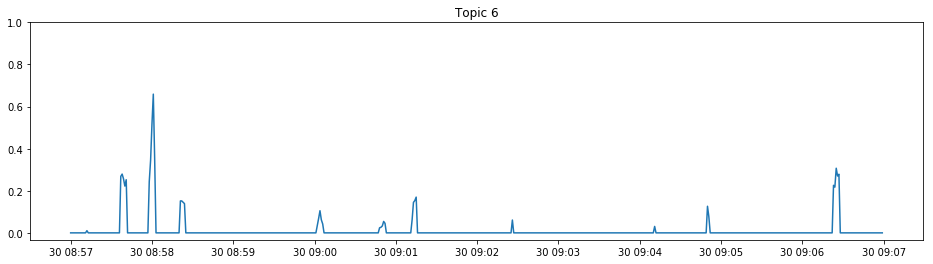

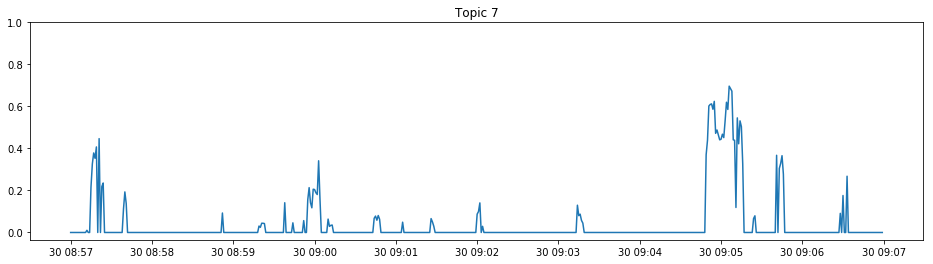

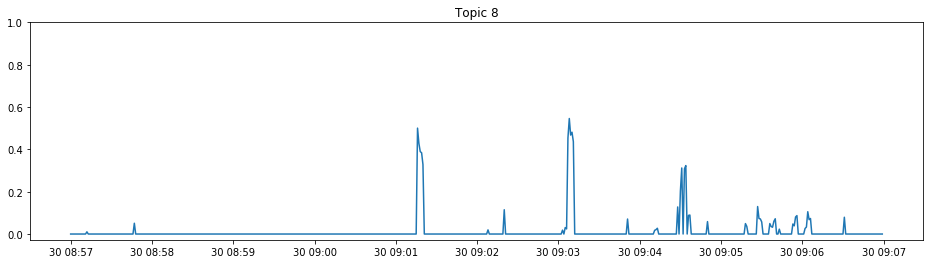

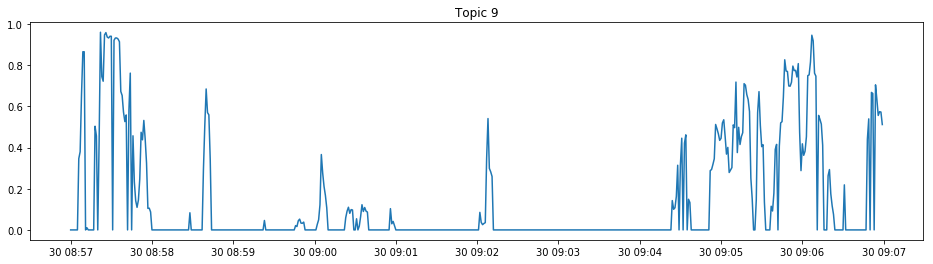

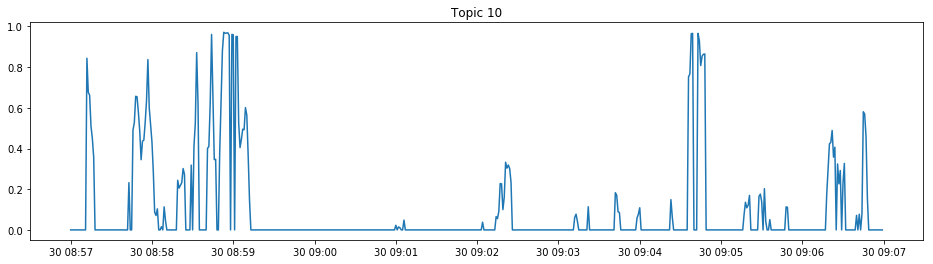

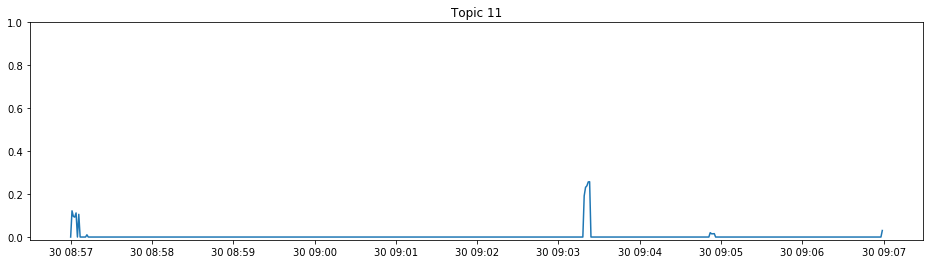

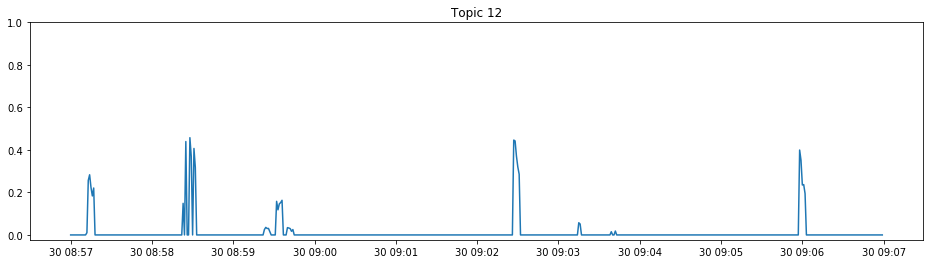

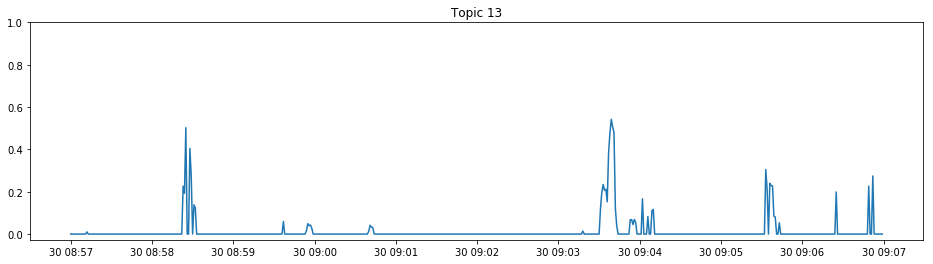

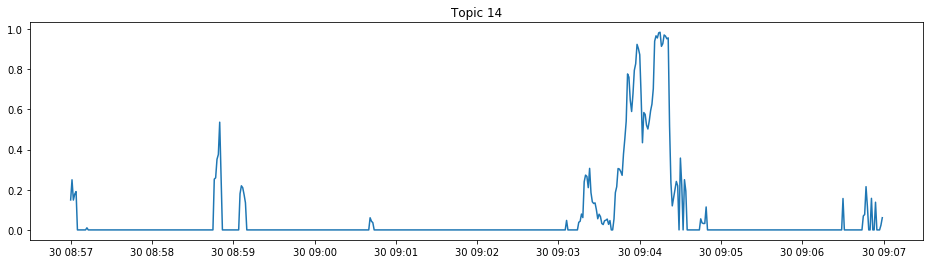

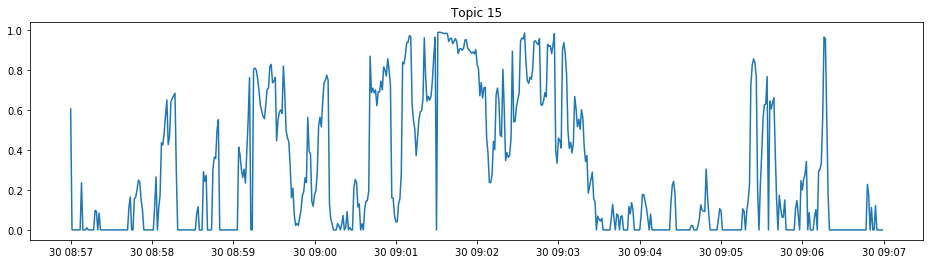

In [86]:
# with documents_rolling

for i in range(lda_model.num_topics):
    plt.figure(figsize = (16,4))
    plt.plot(time_series[i][0:600])
    plt.title(f"Topic {i}")
    plt.yticks([0,0.2,0.4,0.6,0.8,1])

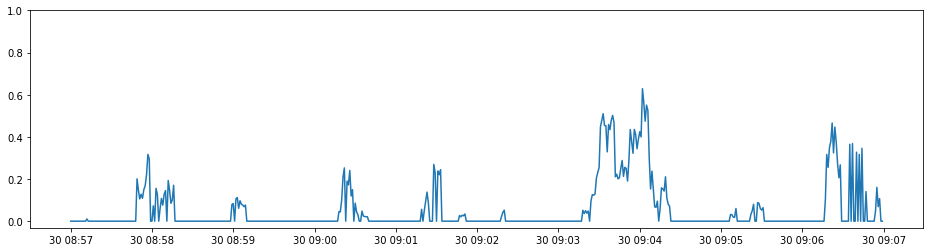

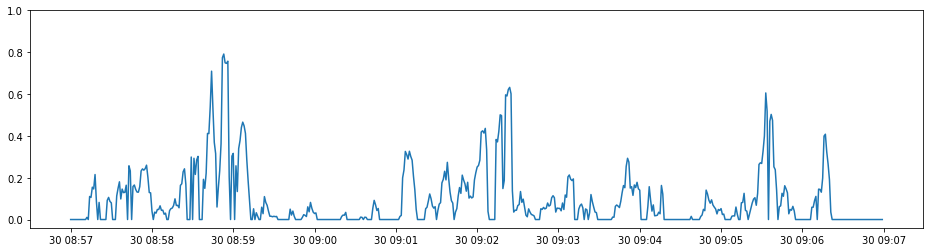

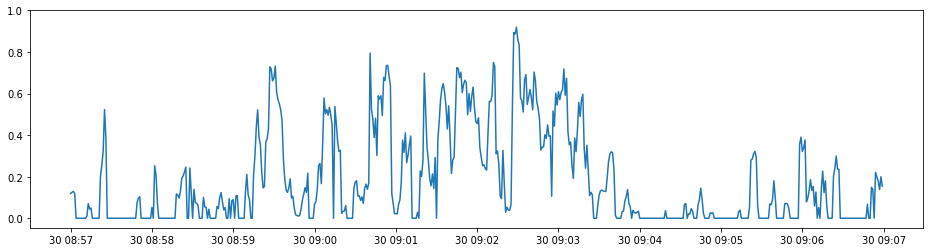

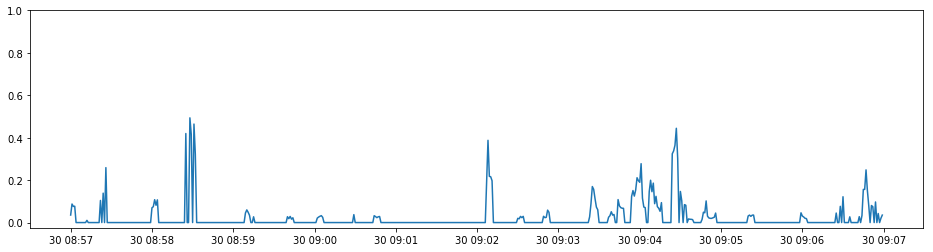

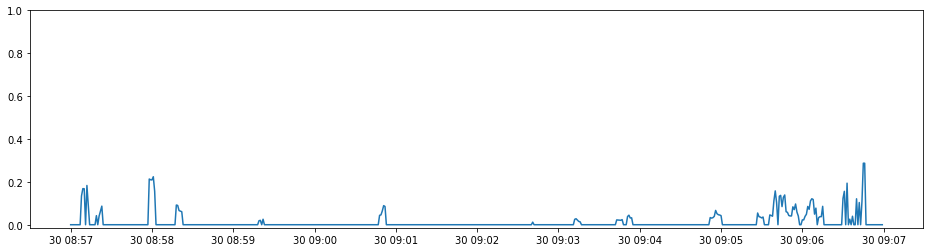

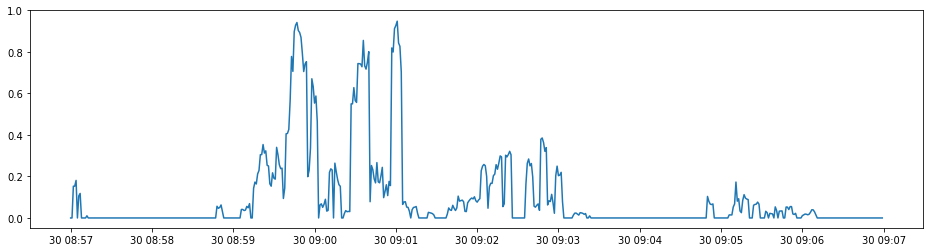

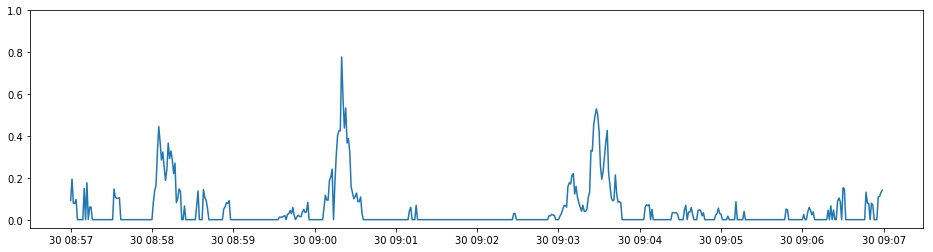

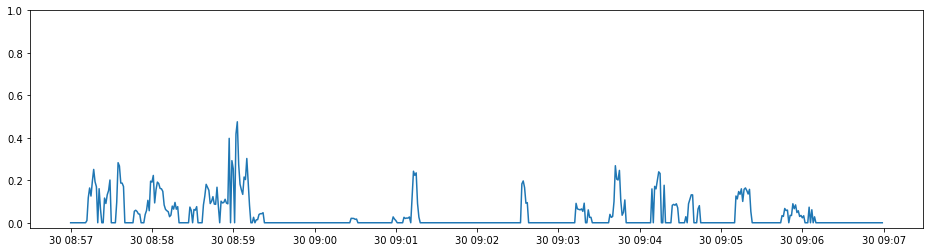

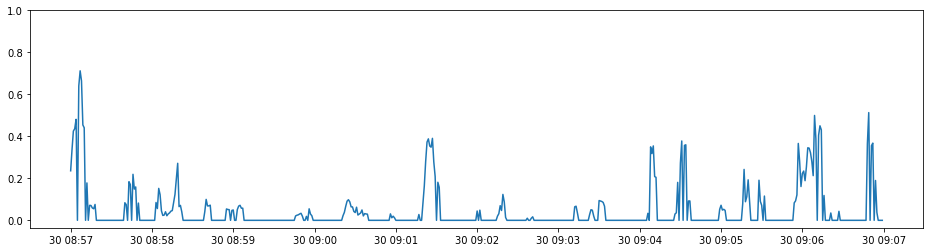

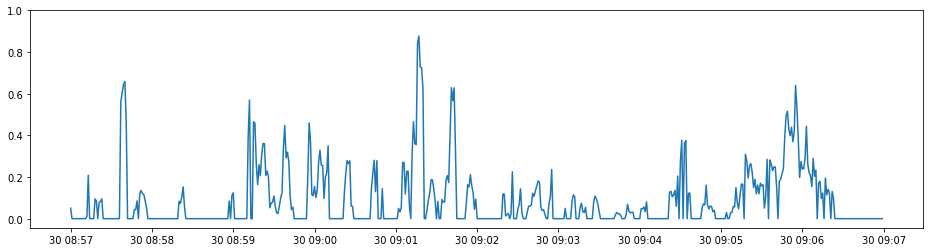

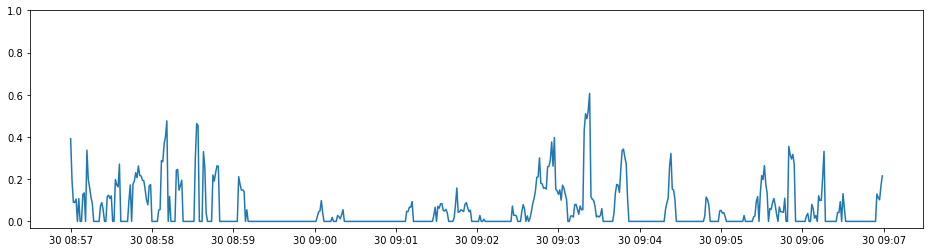

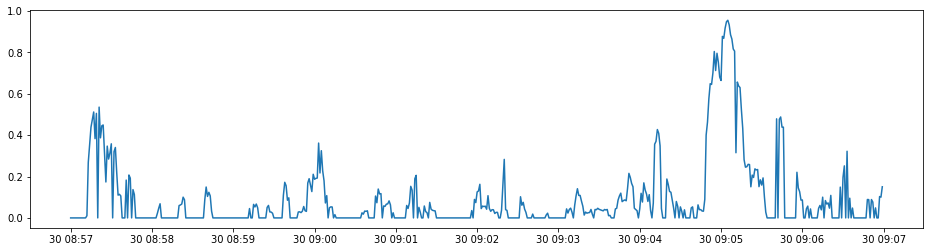

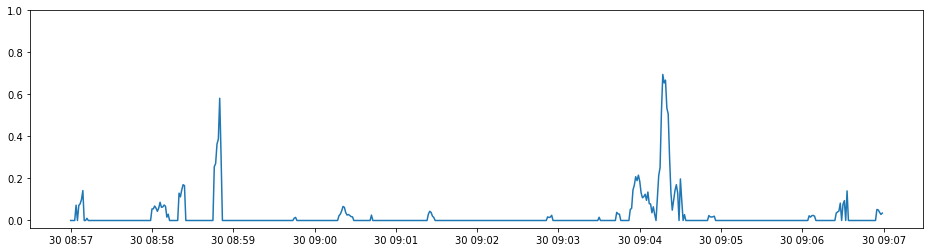

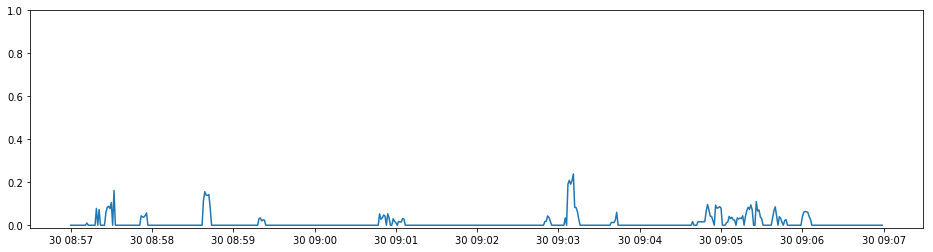

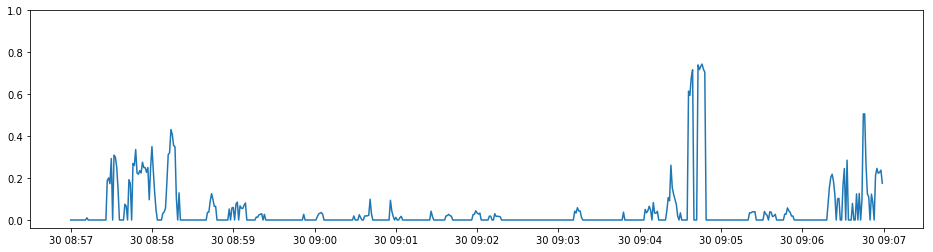

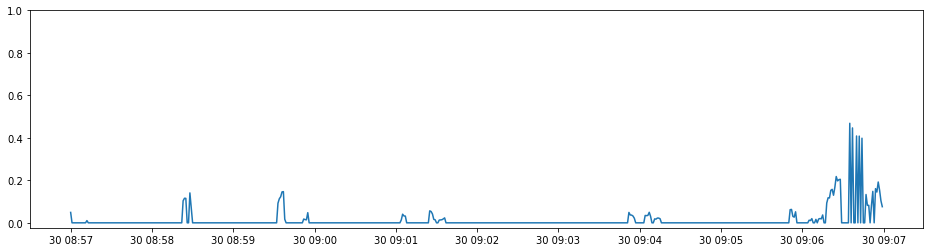

In [31]:
for i in range(lda_model.num_topics):
    plt.figure(figsize = (16,4))
    plt.plot(time_series[i][0:600])
    plt.yticks([0,0.2,0.4,0.6,0.8,1])

In [114]:
time_series[time_series[0] > 0.93].head()

,mps,doc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,highlight
2019-04-30 09:00:20,12,G OMEGALUL R P LUL LULW OMEGALUL LULW OMEGALUL...,0.960554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.027779,1
2019-04-30 09:00:22,13,LULW LULW FORSEN Pog pepeLaugh LULE OMEGALUL O...,0.982311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1
2019-04-30 09:06:35,1,Bruh,0.974660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1
2019-04-30 09:06:37,3,doing ur mom pepeLaugh iquaretz HyperChikaCraz...,0.974660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1
2019-04-30 09:48:07,6,WTFF ⠄⡄⡆⡄⠄⠄⠄⠄⠄⢀⡤⠄⠒⠄⠄⠄⣄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⣄⣠⠄ ⢱⣼⣿⠇⢀⠄⠄⠄⡰⠅...,0.940520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044895,0.0,0.000000,0


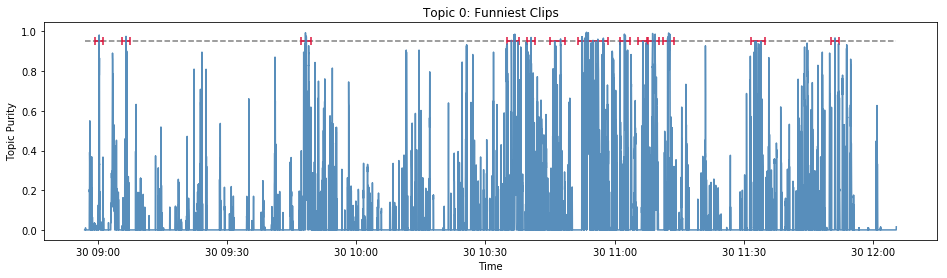

In [113]:
thresh = 0.95

time_series["highlight"] = (time_series[0] > thresh) * 1

plt.figure(figsize = (16,4))
plt.plot(time_series[0],
         c = "steelblue",
         alpha = 0.9)

plt.hlines(thresh, 
           time_series.index.min(), 
           time_series.index.max(), 
           colors = "k", 
           linestyles = "dashed",
           alpha = 0.5)

for clip in hl.get_highlights_timestamp(time_series, before_time = 60, after_time = 60):

    plt.hlines(thresh, 
               clip[0], 
               clip[1], 
               colors = "crimson")
    
    plt.vlines(clip[0], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")
    
    plt.vlines(clip[1], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")



plt.yticks([0,0.2,0.4,0.6,0.8,1]) 

plt.title("Topic 0: Funniest Clips")
plt.xlabel("Time")
plt.ylabel("Topic Purity");

# plt.savefig("../assets/images/topic_modeling_single_game.png");

In [111]:
game = time_series["2019-04-30 10:29:26":"2019-04-30 11:14:00"]

game.head()

,mps,doc,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,highlight
2019-04-30 10:29:26,1,@AdmiralBulldog I can megasub but I wont 4Head,0.0,0.421759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.532178,0.0,0.0,0.0,0.0,0.0,0
2019-04-30 10:29:27,0,,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
2019-04-30 10:29:28,0,,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
2019-04-30 10:29:29,0,,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0
2019-04-30 10:29:30,0,,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0


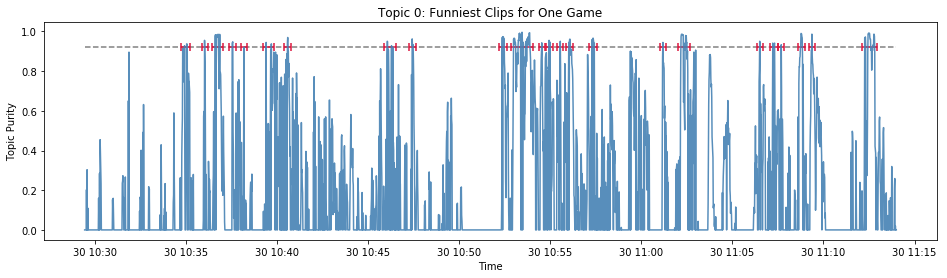

In [131]:
thresh = 0.92

game["highlight"] = (game[0] > thresh) * 1

plt.figure(figsize = (16,4))
plt.plot(game[0],
         c = "steelblue",
         alpha = 0.9)

plt.hlines(thresh, 
           game.index.min(), 
           game.index.max(), 
           colors = "k", 
           linestyles = "dashed",
           alpha = 0.5)

for clip in hl.get_highlights_timestamp(game, before_time = 10, after_time = 10):

    plt.hlines(thresh, 
               clip[0], 
               clip[1], 
               colors = "crimson")
    
    plt.vlines(clip[0], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")
    
    plt.vlines(clip[1], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")



plt.yticks([0,0.2,0.4,0.6,0.8,1]) 

plt.title("Topic 0: Funniest Clips for One Game")
plt.xlabel("Time")
plt.ylabel("Topic Purity");

plt.savefig("../assets/images/topic_modeling_single_game.png");

In [130]:
hl.clip_stats(hl.get_highlights_timestamp(game,
                                          before_time = 10,
                                          after_time = 10))

24 distinct clips
11:24 total minutes of video


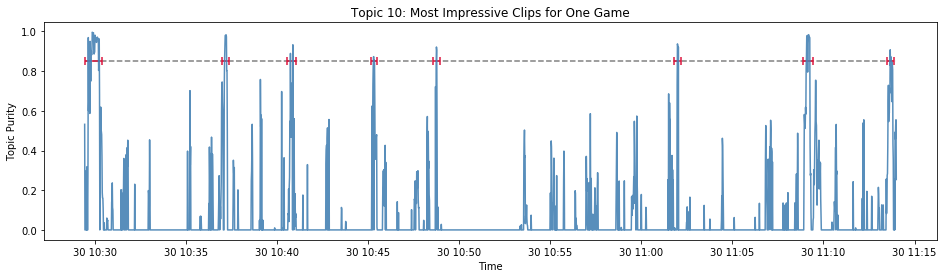

In [138]:
thresh = 0.85

game["highlight"] = (game[10] > thresh) * 1

plt.figure(figsize = (16,4))
plt.plot(game[10],
         c = "steelblue",
         alpha = 0.9)

plt.hlines(thresh, 
           game.index.min(), 
           game.index.max(), 
           colors = "k", 
           linestyles = "dashed",
           alpha = 0.5)

for clip in hl.get_highlights_timestamp(game, before_time = 10, after_time = 10):

    plt.hlines(thresh, 
               clip[0], 
               clip[1], 
               colors = "crimson")
    
    plt.vlines(clip[0], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")
    
    plt.vlines(clip[1], 
               thresh - 0.02, 
               thresh + 0.02, 
               colors = "crimson")



plt.yticks([0,0.2,0.4,0.6,0.8,1]) 

plt.title("Topic 10: Most Impressive Clips for One Game")
plt.xlabel("Time")
plt.ylabel("Topic Purity");

# plt.savefig("../assets/images/topic_modeling_single_game.png");

In [139]:
hl.clip_stats(hl.get_highlights_timestamp(game,
                                          before_time = 10,
                                          after_time = 10))

8 distinct clips
3:49 total minutes of video
